# Section 1

In [1]:
!rm -rf ml-1m.zip
!rm -rf ml-1m

In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip --no-check-certificate
!unzip ml-1m.zip

--2025-08-16 18:47:32--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  7.22MB/s    in 0.8s    

2025-08-16 18:47:33 (7.22 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

# Setting plot style
plt.style.use('ggplot')

In [4]:
users_df = pd.read_csv('ml-1m/users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip'], engine='python')
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

In [5]:
display(users_df.head())
display(movies_df.head())
display(ratings_df.head())

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
users_df.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [7]:
# Grouping user data into male and female age groups
user_age_gender_data = users_df[['age', 'gender']]
female_user_ages = user_age_gender_data.loc[user_age_gender_data['gender'] == 'F'].sort_values('age')
male_user_ages = user_age_gender_data.loc[user_age_gender_data['gender'] == 'M'].sort_values('age')


In [8]:
print(f"Number of male users: {len(male_user_ages)}")
print(f"Number of female users: {len(female_user_ages)}")

Number of male users: 4331
Number of female users: 1709


In [9]:
def get_group_count(min_age, max_age, dataset):
    return len(dataset.loc[(dataset['age'] >= min_age) & (dataset['age'] <= max_age)])

In [10]:
G1_male = get_group_count(0, 18, male_user_ages)
G2_male = get_group_count(17, 25, male_user_ages)
G3_male = get_group_count(24, 35, male_user_ages)
G4_male = get_group_count(34, 45, male_user_ages)
G5_male = get_group_count(44, 50, male_user_ages)
G6_male = get_group_count(49, 56, male_user_ages)
G7_male = get_group_count(55, 200, male_user_ages)

G1_female = get_group_count(0, 18, female_user_ages)
G2_female = get_group_count(17, 25, female_user_ages)
G3_female = get_group_count(24, 35, female_user_ages)
G4_female = get_group_count(34, 45, female_user_ages)
G5_female = get_group_count(44, 50, female_user_ages)
G6_female = get_group_count(49, 56, female_user_ages)
G7_female = get_group_count(55, 200, female_user_ages)


In [11]:
G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male

(949, 2343, 2393, 1216, 711, 628, 278)

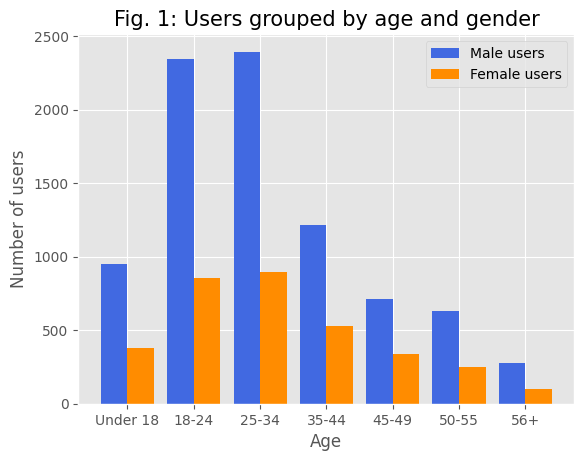

In [12]:
# Figure 1: Visualizing the userbase by plotting age and gender to a bar chart
labels = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
men_grouped = [G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male]
women_grouped = [G1_female, G2_female, G3_female, G4_female, G5_female, G6_female, G7_female]
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, men_grouped, width, label='Male users', color='royalblue')
rects2 = ax1.bar(x + width/2, women_grouped, width, label='Female users', color='darkorange')

# Setting the labels for the bar chart
ax1.set_ylabel('Number of users', size=12)
ax1.set_xlabel('Age', size=12)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Fig. 1: Users grouped by age and gender', size=15)
ax1.legend()

plt.show()

In [13]:
movies_df.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
# Get unique genres
unique_genres = movies_df['genres'].str.split('|', expand=True).stack().unique()
print(unique_genres)

['Animation' "Children's" 'Comedy' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Sci-Fi' 'Documentary' 'War'
 'Musical' 'Mystery' 'Film-Noir' 'Western']


In [15]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [16]:
movies_df.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [17]:
# Check if movie IDs are sequential
num_unique_movie_ids = movies_df['movie_id'].nunique()
max_movie_id = movies_df['movie_id'].max()
min_movie_id = movies_df['movie_id'].min()

if num_unique_movie_ids == max_movie_id and min_movie_id == 1:
    print("The movie IDs are sequential.")
else:
    print("The movie IDs are not sequential.")

The movie IDs are not sequential.


In [18]:
ratings_df.describe()

,user_id,movie_id,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


# Task
Generate a pivot table showing the count of each rating score (columns) for each unique genre (rows) using the data from "movies.csv" and "ratings.csv".

## Merge dataframes

### Subtask:
Merge the `movies_df` and `ratings_df` DataFrames on the `movie_id` column.


**Reasoning**:
Merge the movies and ratings dataframes on the 'movie_id' column to combine movie information with their ratings.



In [19]:
merged_df = pd.merge(movies_df, ratings_df, on='movie_id', how='inner')
display(merged_df.head())

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


## Split genres

### Subtask:
Split the `genres` column into individual genres for each movie.


**Reasoning**:
Split the genres column into a list of individual genres using the '|' delimiter and store it in a new column named 'genre_list'.



In [20]:
merged_df['genre_list'] = merged_df['genres'].str.split('|')
display(merged_df.head())

,movie_id,title,genres,user_id,rating,timestamp,genre_list
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,"[Animation, Children's, Comedy]"
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,"[Animation, Children's, Comedy]"
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,"[Animation, Children's, Comedy]"
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,"[Animation, Children's, Comedy]"
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,"[Animation, Children's, Comedy]"


## Explode genres

### Subtask:
Transform the DataFrame so that each row contains a single genre for a movie and its corresponding rating.


**Reasoning**:
Use the explode method to create a new row for each genre in the genre_list column.



In [21]:
exploded_genres_df = merged_df.explode('genre_list')
display(exploded_genres_df.head())

,movie_id,title,genres,user_id,rating,timestamp,genre_list
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,Comedy
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,Animation
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,Children's


## Pivot table

### Subtask:
Create a pivot table with genres as rows, ratings as columns, and the count of ratings as values.


**Reasoning**:
Create a pivot table with genres as rows, ratings as columns, and the count of ratings as values.



In [22]:
genre_rating_pivot = exploded_genres_df.pivot_table(index='genre_list', columns='rating', values='user_id', aggfunc='count')
display(genre_rating_pivot.head())

rating,1,2,3,4,5
genre_list,,,,,
Action,16531,31432,70728,86579,52187
Adventure,8494,16641,37867,44343,26608
Animation,2097,3587,10973,15841,10795
Children's,5875,8637,20396,23704,13574
Comedy,21616,41073,96946,123415,73530


## Fill missing values

### Subtask:
Fill any missing values in the pivot table with 0.


**Reasoning**:
Fill missing values in the pivot table with 0.



In [23]:
genre_rating_pivot = genre_rating_pivot.fillna(0)
display(genre_rating_pivot.head())

rating,1,2,3,4,5
genre_list,,,,,
Action,16531,31432,70728,86579,52187
Adventure,8494,16641,37867,44343,26608
Animation,2097,3587,10973,15841,10795
Children's,5875,8637,20396,23704,13574
Comedy,21616,41073,96946,123415,73530


## Summary:

### Data Analysis Key Findings

* A pivot table was successfully created showing the count of each rating score (1.0 to 5.0) for each unique genre.
* The pivot table uses genres as the index, rating scores as the columns, and the count of user IDs as the values.
* Missing values in the pivot table, representing combinations of genres and ratings that did not occur, were filled with 0.0.

### Insights or Next Steps

* Analyze the pivot table to identify which genres receive the highest counts of specific rating scores (e.g., which genres have the most 5-star ratings).
* Calculate the percentage of each rating score within each genre to understand the distribution of ratings more effectively.


In [24]:
genre_rating_pivot

rating,1,2,3,4,5
genre_list,,,,,
Action,16531,31432,70728,86579,52187
Adventure,8494,16641,37867,44343,26608
Animation,2097,3587,10973,15841,10795
Children's,5875,8637,20396,23704,13574
Comedy,21616,41073,96946,123415,73530
Crime,3219,7433,19542,28454,20893
Documentary,271,477,1446,3032,2684
Drama,12114,29154,84821,131811,96629
Fantasy,2367,4729,10491,11725,6989


In [25]:
genre_rating_pivot['total'] = genre_rating_pivot.sum(axis=1)
genre_rating_pivot

rating,1,2,3,4,5,total
genre_list,,,,,,
Action,16531,31432,70728,86579,52187,257457
Adventure,8494,16641,37867,44343,26608,133953
Animation,2097,3587,10973,15841,10795,43293
Children's,5875,8637,20396,23704,13574,72186
Comedy,21616,41073,96946,123415,73530,356580
Crime,3219,7433,19542,28454,20893,79541
Documentary,271,477,1446,3032,2684,7910
Drama,12114,29154,84821,131811,96629,354529
Fantasy,2367,4729,10491,11725,6989,36301


In [26]:
genre_rating_pivot

rating,1,2,3,4,5,total
genre_list,,,,,,
Action,16531,31432,70728,86579,52187,257457
Adventure,8494,16641,37867,44343,26608,133953
Animation,2097,3587,10973,15841,10795,43293
Children's,5875,8637,20396,23704,13574,72186
Comedy,21616,41073,96946,123415,73530,356580
Crime,3219,7433,19542,28454,20893,79541
Documentary,271,477,1446,3032,2684,7910
Drama,12114,29154,84821,131811,96629,354529
Fantasy,2367,4729,10491,11725,6989,36301


In [27]:
genre_rating_pivot['weighted_avg_rating'] = (
    genre_rating_pivot[1] * 1 +
    genre_rating_pivot[2] * 2 +
    genre_rating_pivot[3] * 3 +
    genre_rating_pivot[4] * 4 +
    genre_rating_pivot[5] * 5
) / genre_rating_pivot['total']

display(genre_rating_pivot)

rating,1,2,3,4,5,total,weighted_avg_rating
genre_list,,,,,,,
Action,16531,31432,70728,86579,52187,257457,3.491185
Adventure,8494,16641,37867,44343,26608,133953,3.477257
Animation,2097,3587,10973,15841,10795,43293,3.684868
Children's,5875,8637,20396,23704,13574,72186,3.422035
Comedy,21616,41073,96946,123415,73530,356580,3.522099
Crime,3219,7433,19542,28454,20893,79541,3.708679
Documentary,271,477,1446,3032,2684,7910,3.933123
Drama,12114,29154,84821,131811,96629,354529,3.766332
Fantasy,2367,4729,10491,11725,6989,36301,3.447371


In [28]:
genre_ratings_df = genre_rating_pivot.reset_index()
genre_ratings_df = genre_ratings_df[['genre_list', 1, 2, 3, 4, 5, 'total', 'weighted_avg_rating']]
genre_ratings_df.columns = ['Genre', 'Rated 1', 'Rated 2', 'Rated 3', 'Rated 4', 'Rated 5', 'total', 'weighted_avg_rating']
display(genre_ratings_df)

,Genre,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,total,weighted_avg_rating
0,Action,16531,31432,70728,86579,52187,257457,3.491185
1,Adventure,8494,16641,37867,44343,26608,133953,3.477257
2,Animation,2097,3587,10973,15841,10795,43293,3.684868
3,Children's,5875,8637,20396,23704,13574,72186,3.422035
4,Comedy,21616,41073,96946,123415,73530,356580,3.522099
5,Crime,3219,7433,19542,28454,20893,79541,3.708679
6,Documentary,271,477,1446,3032,2684,7910,3.933123
7,Drama,12114,29154,84821,131811,96629,354529,3.766332
8,Fantasy,2367,4729,10491,11725,6989,36301,3.447371
9,Film-Noir,266,829,3224,6889,7053,18261,4.075188


In [29]:
genre_ratings_df.columns

Index(['Genre', 'Rated 1', 'Rated 2', 'Rated 3', 'Rated 4', 'Rated 5', 'total',
       'weighted_avg_rating'],
      dtype='object')

In [30]:
genre_ratings_df.sort_values(by='total', ascending=False)

,Genre,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,total,weighted_avg_rating
4,Comedy,21616,41073,96946,123415,73530,356580,3.522099
7,Drama,12114,29154,84821,131811,96629,354529,3.766332
0,Action,16531,31432,70728,86579,52187,257457,3.491185
15,Thriller,10081,21256,50127,66808,41408,189680,3.570466
14,Sci-Fi,11052,20153,42892,50756,32441,157294,3.466521
13,Romance,6347,15249,40428,53440,32059,147523,3.607465
1,Adventure,8494,16641,37867,44343,26608,133953,3.477257
5,Crime,3219,7433,19542,28454,20893,79541,3.708679
10,Horror,8928,11970,21400,21926,12162,76386,3.215013
3,Children's,5875,8637,20396,23704,13574,72186,3.422035


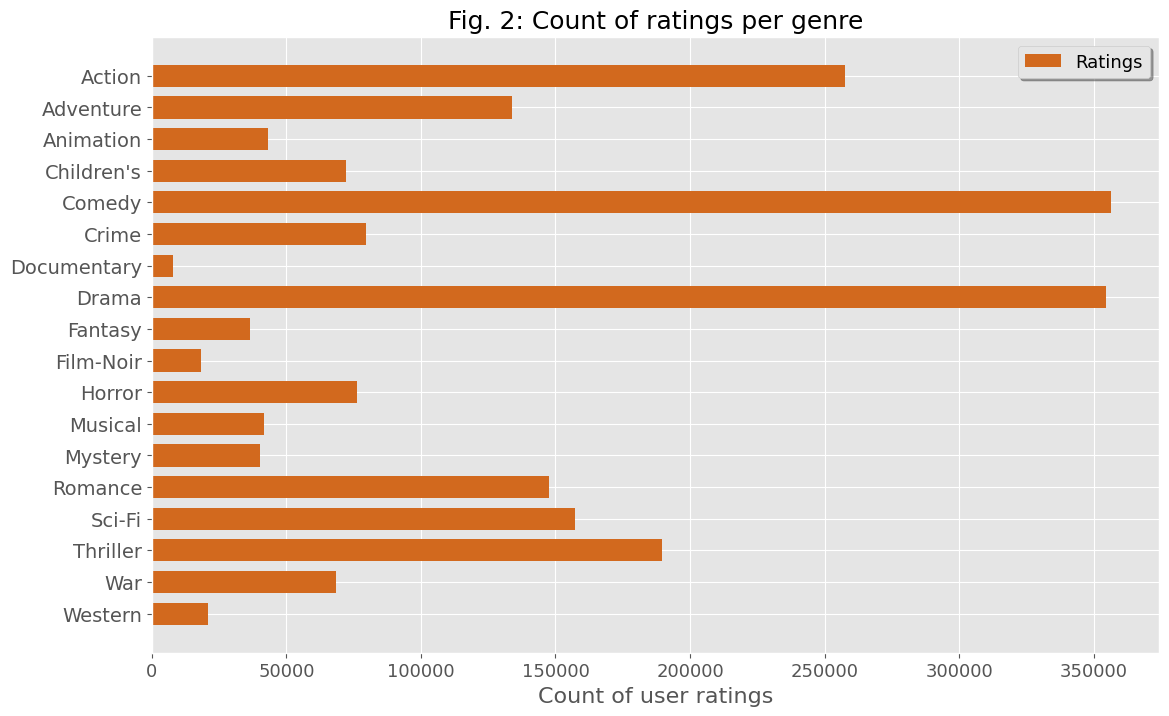

In [31]:
# Figure 2: Visualizing the number of ratings and rating scores for each genre
total_ratings = genre_ratings_df.iloc[:, 6].values.tolist()
fig2, ax2 = plt.subplots()
fig2_labels = [genre for genre in genre_ratings_df['Genre']]
x = np.arange(len(fig2_labels))  # the label locations
width = 0.7  # the width of the bars
ax2.barh(x, total_ratings, width, label='Ratings', color='chocolate')

# Setting labels for bar chart
ax2.set_xlabel('Count of user ratings', size=16)
ax2.set_yticks(x)
ax2.set_yticklabels(fig2_labels, fontdict={'fontsize': 14})
ax2.set_title('Fig. 2: Count of ratings per genre', size=18)
ax2.invert_yaxis()  # Invert y axis so that the genres appear alphabetically
ax2.legend(shadow=True, prop={"size": 13})
plt.xticks(fontsize=13)

# Adjusting and displaying the graph
fig2.set_figheight(8)
fig2.set_figwidth(13)
plt.show()

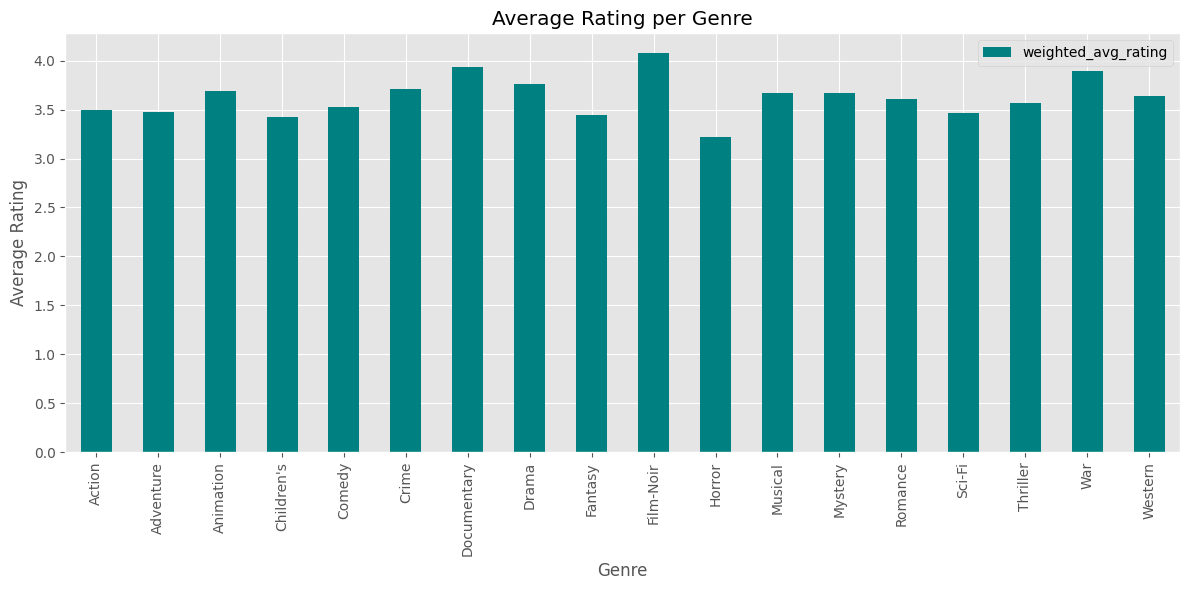

In [32]:
# Plot average rating per genre
fig, ax = plt.subplots(figsize=(12, 6))

genre_ratings_df.plot(x='Genre', y='weighted_avg_rating', kind='bar', ax=ax, color='teal')

ax.set_title('Average Rating per Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Section 2

In [33]:
ratings_df.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object')

In [34]:
X = ratings_df.drop(columns='rating')
y = ratings_df['rating'].values

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

train_df = X_train.copy()
train_df['rating'] = y_train

train_df.head()

,user_id,movie_id,timestamp,rating
868417,5246,2882,961374183,4
201736,1242,3392,975642984,1
898936,5433,3699,960047679,4
580511,3546,1304,966873995,2
380674,2225,2247,974678056,3


In [35]:
len(X_train), len(X_val), len(X_test)

(700146, 150031, 150032)

In [36]:
# Creating a new dataframe with the average rating for each movie.
# The "prediction" for the baseline "model" will actually just be these averages for each movie.
baseline_y_pred = pd.DataFrame(train_df.groupby('movie_id')['rating'].mean())

In [37]:
baseline_y_pred.head()

,rating
movie_id,
1,4.139959
2,3.220408
3,2.943750
4,2.685950
5,2.910000


In [38]:
overall_mean_rating = train_df['rating'].mean()
missing_movies = movies_df[~movies_df['movie_id'].isin(train_df['movie_id'])]

for movie_id in missing_movies['movie_id']:
    baseline_y_pred.loc[movie_id] = overall_mean_rating

In [39]:
len(baseline_y_pred)

3883

In [40]:
print(f"missing movies: {len(missing_movies)}")
print(f"total movies: {len(movies_df)}")
print(f"total ratings: {len(ratings_df)}")
print(f"total unique movies: {len(movies_df['movie_id'].unique())}")
print(f"total unique users: {len(ratings_df['user_id'].unique())}")
print(f"total unique genres: {len(genre_ratings_df['Genre'].unique())}")

missing movies: 228
total movies: 3883
total ratings: 1000209
total unique movies: 3883
total unique users: 6040
total unique genres: 18


In [41]:
val_movies_df = X_val.copy()
val_movies_df['rating'] = y_val

val_movies_df.head()

,user_id,movie_id,timestamp,rating
561012,3451,1210,967241832,4
643498,3878,2243,965837869,4
415445,2503,1291,974084912,4
734004,4386,2762,965173296,5
967494,5831,3385,957898195,3


In [42]:
val_movies_df.rename(columns={'rating': 'actual_rating'}, inplace=True)

In [43]:
val_movies_df = val_movies_df[['movie_id', 'actual_rating']]

In [44]:
val_movies_df.head()

,movie_id,actual_rating
561012,1210,4
643498,2243,4
415445,1291,4
734004,2762,5
967494,3385,3


In [45]:
y_pred_and_y_true = pd.merge(baseline_y_pred, val_movies_df, on='movie_id')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={'rating': 'predicted_rating'})

baseline_y_pred_vs_y_true.head()

,movie_id,predicted_rating,actual_rating
0,1,4.139959,5
1,1,4.139959,5
2,1,4.139959,5
3,1,4.139959,3
4,1,4.139959,5


In [46]:
len(baseline_y_pred_vs_y_true) == len(val_movies_df)

True

In [47]:
print(f"RMSE: {sqrt(mean_squared_error(baseline_y_pred_vs_y_true['actual_rating'], baseline_y_pred_vs_y_true['predicted_rating']))}")

RMSE: 0.981342779969758


In [48]:
content_train_df =pd.merge(train_df, movies_df, on='movie_id')
content_train_df.head()

,user_id,movie_id,timestamp,rating,title,genres
0,5246,2882,961374183,4,Jakob the Liar (1999),Drama
1,1242,3392,975642984,1,She-Devil (1989),Comedy
2,5433,3699,960047679,4,Starman (1984),Adventure|Drama|Romance|Sci-Fi
3,3546,1304,966873995,2,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western
4,2225,2247,974678056,3,Married to the Mob (1988),Comedy


In [49]:
genre_dummies = content_train_df['genres'].str.get_dummies(sep='|')
content_train_df = pd.concat([content_train_df, genre_dummies], axis=1)
display(content_train_df.head())

,user_id,movie_id,timestamp,rating,title,genres,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5246,2882,961374183,4,Jakob the Liar (1999),Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1242,3392,975642984,1,She-Devil (1989),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5433,3699,960047679,4,Starman (1984),Adventure|Drama|Romance|Sci-Fi,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,3546,1304,966873995,2,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2225,2247,974678056,3,Married to the Mob (1988),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
content_train_df.drop(columns=['movie_id', 'timestamp', 'title', 'genres'], inplace=True)
content_train_df.head()

,user_id,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5246,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1242,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5433,4,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
3,3546,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2225,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
len(content_train_df)

700146

In [52]:
# Creating a list of lists with the target attribute (movie ratings), grouped by userID
y_grouped_by_user = content_train_df.groupby(["user_id"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["rating"].values)  # Extract target feature (ratings) from sorted data

# Target attributes for the first user
y_train_listed[0]

array([5, 4, 4, 5, 4, 3, 5, 5, 4, 4, 3, 4, 3, 5, 3, 4, 3, 4, 5, 5, 4, 5,
       4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4])

In [53]:
content_train_df.drop(columns='rating', inplace=True)
x_grouped_by_user = content_train_df.groupby(["user_id"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='user_id'))

x_train_listed[0]

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6162,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
23225,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
46762,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
51403,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
54150,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
56292,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
76786,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
130416,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
160632,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
170620,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [54]:
x_train_listed[0].shape

(37, 18)

In [55]:
y_train_listed[0].shape

(37,)

In [56]:
all_movies = movies_df.drop(columns=['title', 'movie_id'])
all_movies.head()

,genres
0,Animation|Children's|Comedy
1,Adventure|Children's|Fantasy
2,Comedy|Romance
3,Comedy|Drama
4,Comedy


In [57]:
genre_dummies = all_movies['genres'].str.get_dummies(sep='|')
all_movies = pd.concat([all_movies, genre_dummies], axis=1)
all_movies.drop(columns='genres', inplace=True)
display(all_movies.head())

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
from tqdm import tqdm

# 1. List user IDs in the same order as grouped data
user_ids = [user_id[0] for user_id, _ in x_grouped_by_user]

# 2. List movie IDs
movie_ids = movies_df["movie_id"].values

# 3. Prepare validation DataFrame
df_val = X_val.copy()
df_val["rating"] = y_val

# 4. Create the validation matrix using pivot_table and reindex
validation_matrix = df_val.pivot_table(index='user_id', columns='movie_id', values='rating')
validation_matrix = validation_matrix.reindex(index=user_ids, columns=movie_ids)

In [59]:
validation_matrix.shape

(6040, 3883)

In [60]:
len(user_ids)

6040

In [61]:
validation_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# 5. Train a Lasso regression model for each user and predict ratings for all movies
CBF_predictions = []

for i in tqdm(range(len(user_ids))):
    # Get the training data for the current user
    X_train_user = x_train_listed[i]
    y_train_user = y_train_listed[i]

    # Train the Lasso regression model
    lasso_model = Lasso(alpha=0.1)  # You can adjust alpha as needed
    lasso_model.fit(X_train_user, y_train_user)

    # Predict ratings for all movies for the current user
    user_predictions = lasso_model.predict(all_movies)

    # Clip predictions to the range of 1 to 5
    user_predictions = np.clip(user_predictions, 1, 5)

    # Append the predictions to the list
    CBF_predictions.append(user_predictions)

# The CBF_predictions list now contains predicted ratings for all movies for each user

  4%|▍         | 269/6040 [00:00<00:20, 278.61it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 6040/6040 [00:21<00:00, 278.51it/s]


In [63]:
len(CBF_predictions)

6040

## Evaluate Content-Based Filtering Model

### Subtask: Calculate RMSE

In [64]:
# Convert CBF_predictions to a DataFrame for easier handling
cbf_predictions_df = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

In [65]:
cbf_predictions_df

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,4.128571,4.128571,4.128571,4.206250,4.128571,4.128571,4.128571,4.128571,4.128571,4.128571,...,4.128571,4.206250,4.128571,4.206250,4.128571,4.128571,4.206250,4.206250,4.206250,4.206250
2,3.671875,3.671875,3.671875,3.764151,3.671875,3.671875,3.671875,3.671875,3.671875,3.671875,...,3.671875,3.764151,3.671875,3.764151,3.671875,3.671875,3.764151,3.764151,3.764151,3.764151
3,3.878261,3.884211,3.878261,3.878261,3.878261,3.884211,3.878261,3.884211,3.884211,3.884211,...,3.878261,3.878261,3.884211,3.884211,3.884211,3.878261,3.884211,3.884211,3.884211,3.884211
4,4.732371,4.732371,4.732371,4.626453,4.732371,3.685327,4.732371,4.732371,4.732371,3.685327,...,4.732371,4.626453,4.732371,3.579408,3.685327,4.732371,4.626453,4.626453,4.626453,3.579408
5,3.302651,3.260907,3.302651,3.302651,3.302651,3.160543,3.302651,3.260907,3.182826,3.160543,...,3.302651,3.302651,3.260907,3.160543,3.238623,3.302651,3.260907,3.260907,3.260907,3.238623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,...,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258
6037,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,...,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496,3.730496
6038,4.250001,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818,...,4.181818,4.181818,4.250001,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818,4.181818
6039,3.869767,3.941463,3.869767,3.869767,3.869767,3.941463,3.869767,3.941463,3.941463,3.941463,...,3.869767,3.869767,3.941463,3.941463,3.941463,3.869767,3.941463,3.941463,3.941463,3.941463


In [66]:
# Align the predicted ratings with the actual ratings in the validation matrix
# We will use the validation_matrix which already has the correct structure and NaNs for missing values
aligned_predictions = cbf_predictions_df.stack()
aligned_actuals = validation_matrix.stack()

print(aligned_predictions)
print(aligned_actuals)

1     1       4.128571
      2       4.128571
      3       4.128571
      4       4.206250
      5       4.128571
                ...   
6040  3948    3.386713
      3949    3.661640
      3950    3.661640
      3951    3.661640
      3952    3.661640
Length: 23453320, dtype: float64
user_id  movie_id
1        1           5.0
         527         5.0
         594         4.0
         938         4.0
         1028        5.0
                    ... 
6040     2624        5.0
         2750        2.0
         2858        4.0
         3083        4.0
         3097        4.0
Length: 150031, dtype: float64


In [67]:
# Create a DataFrame with aligned predictions and actuals
cbf_y_pred_vs_y_true = pd.DataFrame({
    'predicted_rating': aligned_predictions,
    'actual_rating': aligned_actuals
})

display(cbf_y_pred_vs_y_true)

predicted_rating  actual_rating
1    1             4.128571            5.0
     2             4.128571            NaN
     3             4.128571            NaN
     4             4.206250            NaN
     5             4.128571            NaN
...                     ...            ...
6040 3948          3.386713            NaN
     3949          3.661640            NaN
     3950          3.661640            NaN
     3951          3.661640            NaN
     3952          3.661640            NaN

[23453320 rows x 2 columns]

In [68]:
# Drop rows where actual rating is NaN (these were not in the validation set)
cbf_y_pred_vs_y_true.dropna(inplace=True)

# Calculate RMSE
cbf_rmse = sqrt(mean_squared_error(cbf_y_pred_vs_y_true['actual_rating'], cbf_y_pred_vs_y_true['predicted_rating']))

print(f"Content-Based Filtering RMSE: {cbf_rmse}")

Content-Based Filtering RMSE: 1.028913107872624


# UBCF

In [69]:
train_df.head()

,user_id,movie_id,timestamp,rating
868417,5246,2882,961374183,4
201736,1242,3392,975642984,1
898936,5433,3699,960047679,4
580511,3546,1304,966873995,2
380674,2225,2247,974678056,3


In [70]:
train_df.shape

(700146, 4)

In [71]:
import numpy as np

# --- Step 1. Encode users & movies into integer indices ---
user_list = train_df["user_id"].unique()
movie_list = train_df["movie_id"].unique()

user2idx = {u: i for i, u in enumerate(user_list)}
movie2idx = {m: i for i, m in enumerate(movie_list)}

# Map to indices
train_users = train_df["user_id"].map(user2idx).to_numpy()
train_movies = train_df["movie_id"].map(movie2idx).to_numpy()
train_ratings = train_df["rating"].to_numpy()

val_users = X_val["user_id"].map(user2idx).to_numpy()
val_movies = X_val["movie_id"].map(movie2idx).to_numpy()

# --- Step 2. Build user–movie rating matrix (dense) ---
n_users = len(user_list)
n_movies = len(movie_list)

user_matrix = np.zeros((n_users, n_movies), dtype=np.float32)
for u, m, r in zip(train_users, train_movies, train_ratings):
    user_matrix[u, m] = r

# --- Step 3. Normalize ratings (mean-center per user) ---
row_means = np.true_divide(
    user_matrix.sum(1),
    (user_matrix != 0).sum(1),
    where=(user_matrix != 0).sum(1) != 0
)
user_matrix = user_matrix - row_means[:, None]
user_matrix[user_matrix == -row_means[:, None]] = 0  # restore missing as 0

# --- Step 4. Compute Pearson correlation between users ---
# corrcoef works on rows=users if we pass rowvar=True
user_corr = pd.DataFrame(user_matrix).T.corr(method="pearson").to_numpy()
user_corr = np.nan_to_num(user_corr, nan=0.0)
user_dist_matrix = 1 - user_corr

# --- Step 5. Build movie→(users, ratings) lookup ---
movie_user_map = {}
for m in np.unique(train_movies):
    mask = (train_movies == m)
    movie_user_map[m] = (train_users[mask], train_ratings[mask])

# --- Step 6. Global average as fallback ---
global_avg = train_ratings.mean()

# --- Step 7. Predict for validation set ---
CF_predictions = np.empty(len(val_users), dtype=float)

for i, (u, m) in enumerate(zip(val_users, val_movies)):
    if m in movie_user_map:  # movie exists in training
        users_rated, ratings_rated = movie_user_map[m]

        sims = user_dist_matrix[u, users_rated]

        # take top-40 nearest
        if len(sims) > 40:
            top_idx = np.argpartition(sims, 40)[:40]
            sims = sims[top_idx]
            ratings_rated = ratings_rated[top_idx]

        # weights = inverse distance (avoid div by zero)
        with np.errstate(divide="ignore"):
            weights = 1.0 / sims
        weights[~np.isfinite(weights)] = 0

        if weights.sum() > 0:
            CF_predictions[i] = np.average(ratings_rated, weights=weights)
        else:
            CF_predictions[i] = global_avg
    else:
        CF_predictions[i] = global_avg


In [73]:
print("RMSE KNN_40:", sqrt(mean_squared_error(y_val, CF_predictions)))

RMSE KNN_40: 0.9558051868328877


In [76]:
CBF_y_pred_df = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

In [77]:
CBF_y_pred = [CBF_y_pred_df.loc[row["user_id"], row["movie_id"]] for _, row in X_val.iterrows()]
weighted_avgs = [(0.5, 0.5), (0.4, 0.6), (0.35, 0.65)]


In [80]:
for weight in weighted_avgs:
    combined_predictions = (np.array(CBF_y_pred) * weight[0]) + (np.array(CF_predictions) * weight[1])
    print(f"RMSE for CBF {weight[0]}, CF {weight[1]}:", sqrt(mean_squared_error(y_val, combined_predictions)))


RMSE for CBF 0.5, CF 0.5: 0.9313995701605302
RMSE for CBF 0.4, CF 0.6: 0.9261423243003429
RMSE for CBF 0.35, CF 0.65: 0.9254269603513434


In [85]:
CBF_predictions_test = [CBF_y_pred_df.loc[row["user_id"], row["movie_id"]] for _, row in X_test.iterrows()]


In [83]:
test_users = X_test["user_id"].map(user2idx).to_numpy()
test_movies = X_test["movie_id"].map(movie2idx).to_numpy()


# --- Step 7. Predict for validation set ---
CF_predictions = np.empty(len(X_test), dtype=float)

for i, (u, m) in enumerate(zip(test_users, test_movies)):
    if m in movie_user_map:  # movie exists in training
        users_rated, ratings_rated = movie_user_map[m]

        sims = user_dist_matrix[u, users_rated]

        # take top-40 nearest
        if len(sims) > 40:
            top_idx = np.argpartition(sims, 40)[:40]
            sims = sims[top_idx]
            ratings_rated = ratings_rated[top_idx]

        # weights = inverse distance (avoid div by zero)
        with np.errstate(divide="ignore"):
            weights = 1.0 / sims
        weights[~np.isfinite(weights)] = 0

        if weights.sum() > 0:
            CF_predictions[i] = np.average(ratings_rated, weights=weights)
        else:
            CF_predictions[i] = global_avg
    else:
        CF_predictions[i] = global_avg

In [89]:
hybrid_predictions_test = (np.array([y_pred * 0.5 for y_pred in CBF_predictions_test]) + np.array([y_pred * 0.5 for y_pred in CF_predictions]))
print(f"RMSE hybrid recommendations (test data): {sqrt(mean_squared_error(y_test, hybrid_predictions_test))}")


RMSE hybrid recommendations (test data): 0.9305650334352956
